<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/Copy_of_Week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FM 5222 
# Week 12


Agenda

1) Bayesian Posteriors

2) Simulating from the posterior distribution

3) Using pymc3 and examples

4) Some observations about priors


5) Fitting some actual data




## Bayesian Posteriors

We usse Baysian posteriors is generally in the following context

* We have data that we believe are generated from a known distribution but with $p$ unkown parameters.  



* Though the parameters are unkown, we have some prior information on what they might be. We express this information as a prior distribution.



Suppose our data is give by $y = (y_1,y_2,...,y_N)$ and their distribution is given by $f(x;\theta_1,\theta_2,...,\theta_p)$


The prior distribution (expressing what we know about the parameters) is given by

$g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta_1, \eta_2,...,\eta_m) = g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta)$


Here the parameters of prior distribution are denoted by $\eta = (\eta_1, \eta_2,...,\eta_m)$.  These are sometimes called *hyper-parameters* to avoid confusing them with the parameters of $f$.


Given our observations, we can state the posterior distribution for the $\theta$ parameters:


$$g_{\Theta}(\theta_1, \theta_2,...,\theta_p| y) = \frac{\left(\Pi_{k=1}^n f(y_k;\theta_1, \theta_2,...,\theta_p)\right)g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta)}{\int \cdots \int \left(\Pi_{k=1}^n f(y_k;\theta_1, \theta_2,...,\theta_p)\right)g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta) d\theta_1 \cdots d\theta_p}$$


We note that the messy integral in the denominator is just a number, and really only serves the purpose of ensuring that that the posterior actually is a pdf (it will integrate to 1).






#### Historically, working with Baysian posteriors was hard

The calculations necessary to capture things like the mode (requires optimization) or the mean (requires integration) of the posterior and numerically tricky. It takes effort to not suffer from signifigant round-off error.


On the other hand, if we restrict ourselves to conjugate priors, things are nice since we don't need to perform difficult numerical calculations.  But restricting to conjugate priors limits us to situations where they apply - and are understood.




## Simulating the Posterior

Instead of directly calculating items of interest (like mode and mean), what if we can generate large samples of data that follow the posterior distribution (note: this data will be  samples of the *parameters*).   Then, we can easily calculate the mean (sample mean) and typically can infer a mode using binning or a kde). 


The tool we have to do this is called Markov Chain Monte Carlo (MCMC).  

We consider our expressino above:


$$g_{\Theta}(\theta_1, \theta_2,...,\theta_p| y) = \frac{\left(\Pi_{k=1}^n f(y_k;\theta_1, \theta_2,...,\theta_p)\right)g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta)}{\int \cdots \int \left(\Pi_{k=1}^n f(y_k;\theta_1, \theta_2,...,\theta_p)\right)g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta) d\theta_1 \cdots d\theta_p}$$


and note that we can write


$$g_{\Theta}(\theta_1, \theta_2,...,\theta_p| y) \propto \left(\Pi_{k=1}^n f(y_k;\theta_1, \theta_2,...,\theta_p)\right)g_{\Theta}(\theta_1, \theta_2,...,\theta_p; \eta)$$


It turns out that we only need to define distributions up to a multiple in order to generate sample from it.  That is one of the key advantages of MCMC.



How can this be done?  It turns out that there are several such algorithms. The most famous of which is the Metropolis-Hastings algorithm.

There are other that can be faster provided the pdf's involved can be differentiated symbolically by a computer.  One we will soon see is called the "No U Turn Sampler" (NUTS).

For now, I am going to treat them as black boxes and show you how to use a python package called pymc3 to generate such samples.


Next week, I will give you a hint on how they work, most likely in a video.


## Using pymc3

We start by loading packages and constructing an example to see the package can be used.



FYI:   Documentation can be found [here](https://docs.pymc.io/en/v3/api.html)

In [1]:
! pip install yfinance

     |████████████████████████████████| 6.4 MB 9.7 MB/s 
     |████████████████████████████████| 63 kB 646 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import pymc3 as pm

import arviz as az

### Example - coin flipping again


We will generate 100 flips with $\theta_{true} = .7$ and use pymc3 to understand the posterior.  We will set the prior to the uniform distribution on $[0,1]$


In [3]:
# generating data
N = 100
theta_true = .7

data = ss.binom.rvs(n = 1, p = theta_true, size = N, random_state = 1981)

In [4]:
data.mean()

0.67

We next need to define a model in pymc3

In [5]:
model_1 = pm.Model()

with model_1:
    
    #define the prior
    
    theta = pm.Uniform('theta', lower= 0, upper = 1)
    
    
    #define the distribution of the observed variables
    
    Y_obs = pm.Bernoulli('Y_obs', p=theta ,  observed=data)

Now we are ready to sample from the posterior

In [6]:
with model_1:
    
    trace = pm.sample(1000)
    
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


The number of chains is determined by how many processsors are available.  You can change it on your computer

In [7]:
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws=1000, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=1000, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, callback=None, jitter_max_retries=10, *, return_inferencedata=None, idata_kwargs: dict = None, mp_ctx=None, pickle_backend: str = 'pickle', **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 1000. The number of tuned samples are discarded
        by default. See ``discard_tuned_samples``.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto: Choose a default initialization method automatically.
          Currently, this is ``jitter+adapt_diag``, but this

Let's take a look at the data that is stored in our trace object.  

We can use the package arviz for this.  (note, pymc3 is now maintained by the arviz people).

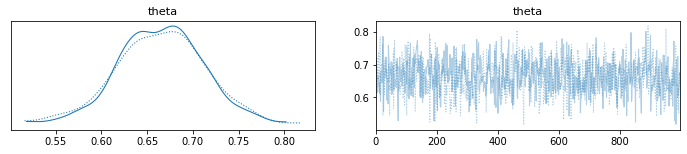

In [8]:
with model_1: 
    
    az.plot_trace(trace)

What we want to see is that the kde's (one for each chain) look similar.  We also want the second plot to show stationarity.   In not, we may need to increese the tune parameter.


Let's look at the PDF (note, this is actually a KDE) when we combine all the chains.

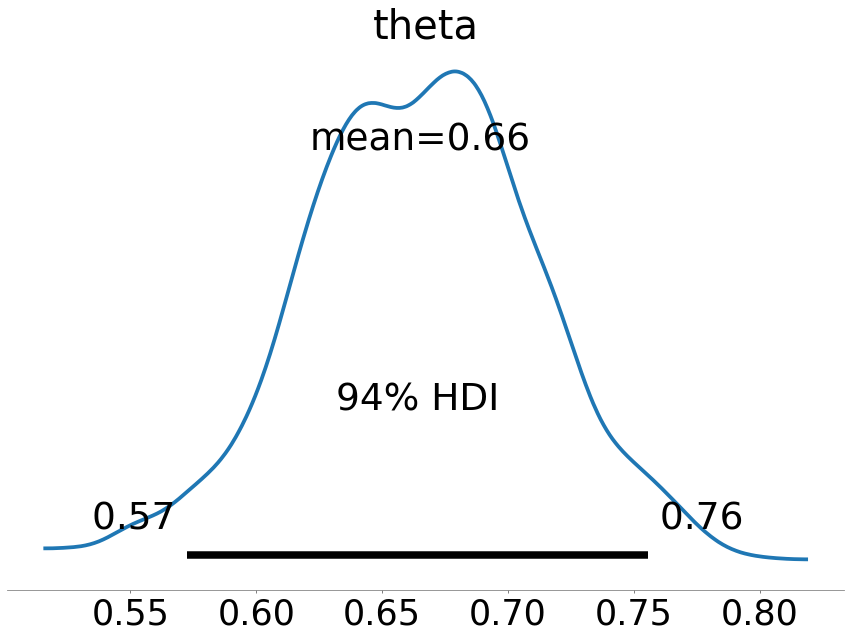

In [9]:
with model_1:

  az.plot_posterior(trace, figsize = (15,10))

We can also get a summary of the samples

In [10]:
with model_1: 
    
    sum1 = az.summary(trace)
    
sum1    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.665,0.048,0.572,0.756,0.002,0.001,853.0,1160.0,1.0


We can also directly access the sampled data if we don't want to use arviz

In [11]:
samples = trace['theta']

type(samples), samples.shape

(numpy.ndarray, (2000,))

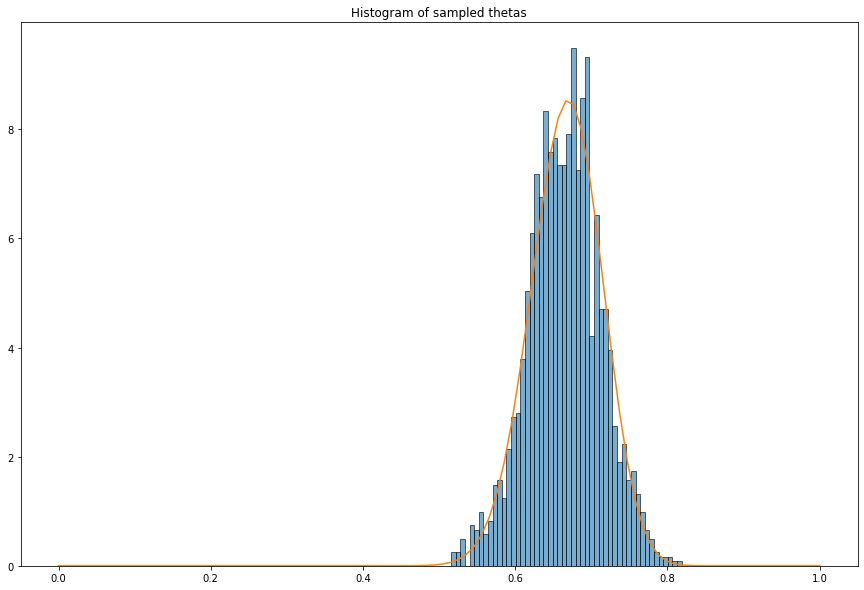

In [12]:
x = np.linspace(0,1,100)


plt.figure(figsize= (15,10))

plt.hist(samples, bins=50, edgecolor = "black", alpha = .6,density = True)

plt.plot(x, ss.beta.pdf(x, a = 68, b = 34))

plt.title("Histogram of sampled thetas")

plt.show()

### Example 2

In this example, we will generate data from the normal distribution with $\mu = 2$ and $\sigma = 2$.

We will have two priors:

For $\mu$, we will take a uniform distribution on $[-5,5]$

For $\sigma$, we will take lognormal distribution with shape parameter $s= 0.5$


Before we even generate data, let's plot the prior for $\sigma$ (for $\mu$, it's boring).

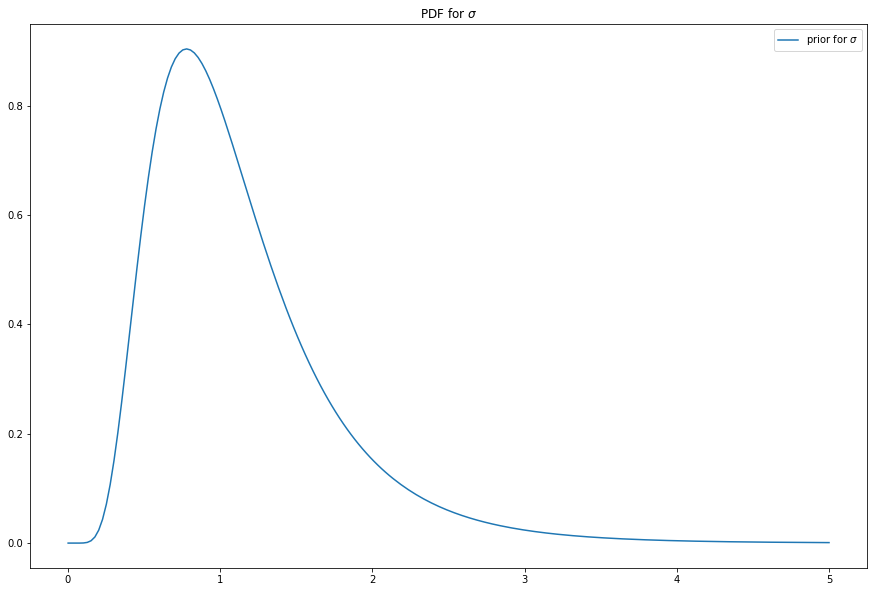

In [13]:
x = np.linspace(0.001,  5, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.lognorm.pdf(x, s= 0.5), label="prior for $\sigma$")

plt.legend()

plt.title("PDF for $\sigma$")

plt.show()

Generate data

In [14]:
N = 100
data2 = ss.norm.rvs(loc = 2, scale = 2, size = N)

Set up our pymc3 model

In [15]:
model_2 = pm.Model()

with model_2:
    
    #define the priors
    
    mu = pm.Uniform('mu', lower= -5, upper = 5)
    
    sigma = pm.Lognormal('sigma', sigma = .5)
    
    
    #define the distribution of the observed variables
    
    Y_obs = pm.Normal('Y_obs', mu = mu , sigma = sigma,  observed=data2)

In [16]:
# Run the sampler


with model_2:
    
    trace2 = pm.sample(1000)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Now we look at what we see

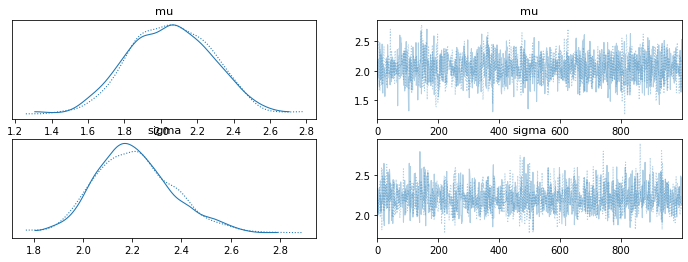

In [17]:
with model_2: 
    
    az.plot_trace(trace2)

Let us compare our posterior for $sigma$ with the prior

In [18]:
sigma_kde =  ss.gaussian_kde(trace2['sigma'])

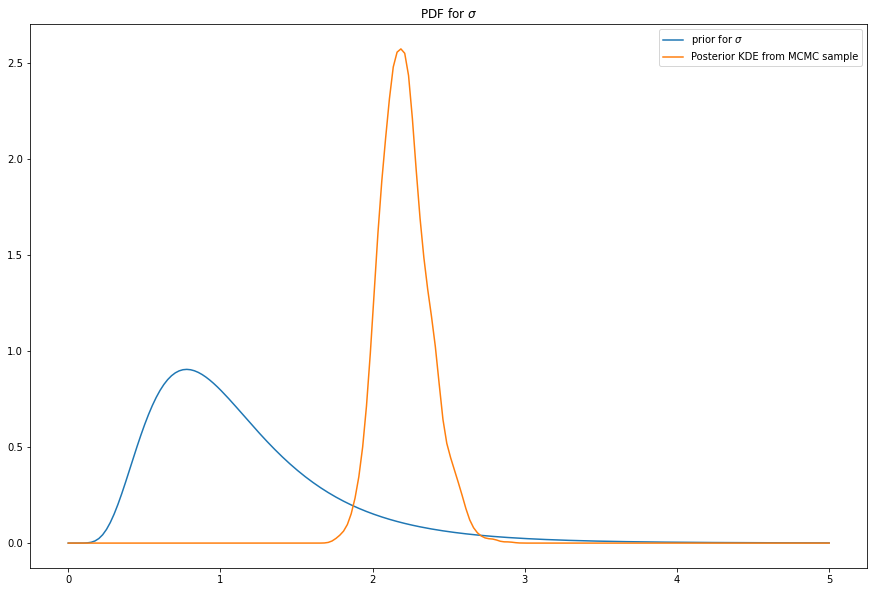

In [19]:
x = np.linspace(0.001,  5, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.lognorm.pdf(x, s= 0.5), label="prior for $\sigma$")

plt.plot(x, sigma_kde(x), label="Posterior KDE from MCMC sample")

plt.legend()

plt.title("PDF for $\sigma$")

plt.show()

A comment is in order here.

As priors, we treated $\mu$ and $\sigma$ and indepedendent random variables.  The information above looks at the posteriors from a marginal perspective.  However, the data series actually represents the *joint* distribution of $\mu$ and $\sigma$.  Even if they are originally indepdendent, the posterior distribtion will not be (necessarily).

Let's take a quick look:



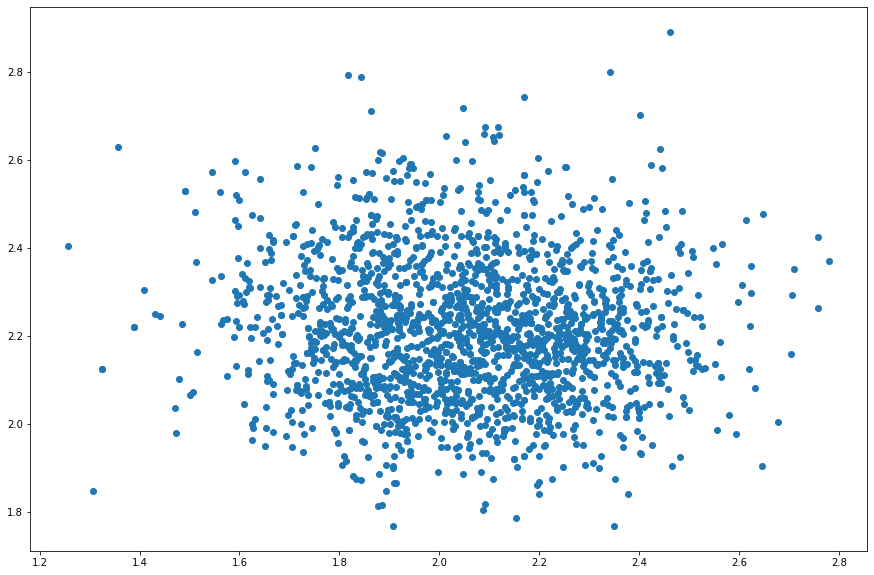

In [20]:
plt.figure(figsize = (15,10))

plt.scatter(trace2['mu'],trace2['sigma'])
                   
plt.show()

In this case, they appear to be independent even as posterior.  But here is an example where they may not be.


### Example 3

The data will be generated from the t distribution with $\nu = 4$.  The location parameter will be $0$ and the scale parameter 1.


For priors, we will say the location is uniform on $[-1,1]$, the scale is gamma with $\alpha = 2$ and $\beta = 1$

For $\nu$ will take lognormal with $\sigma$ parmeter $1$ and $\mu$ parameter 1.5


Again, before we do anything, let us plot the priors for $\nu$ and scale






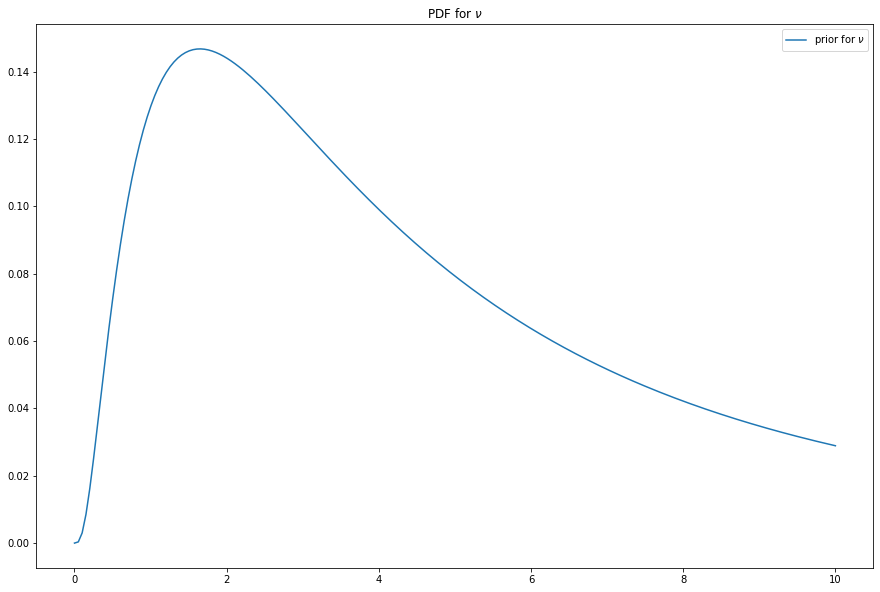

In [21]:
x = np.linspace(0.001,  10, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.lognorm.pdf(x, s= 1, scale = np.exp(1.5)), label="prior for $\\nu$")


plt.legend()

plt.title("PDF for $\\nu$")

plt.show()



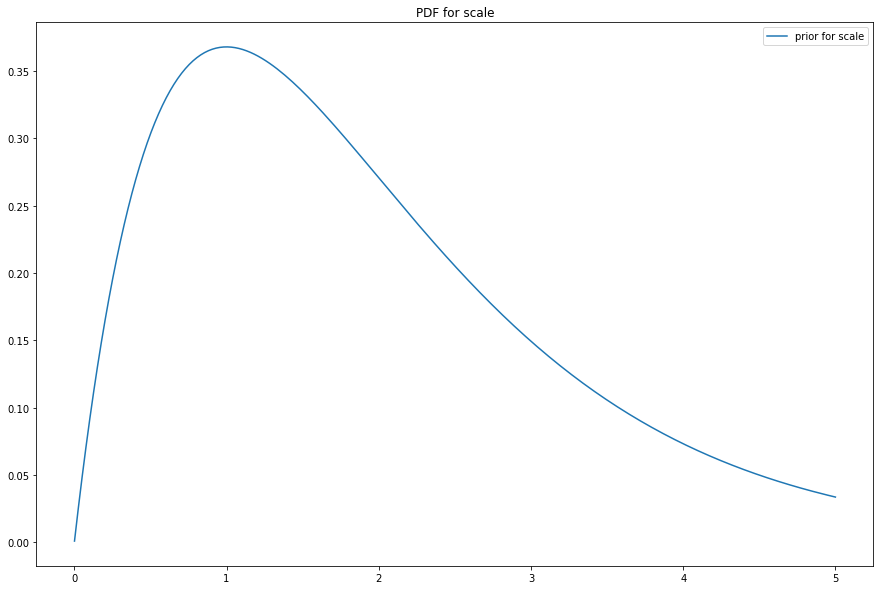

In [22]:
x = np.linspace(0.001,  5, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.gamma.pdf(x, a=2, scale = 1), label="prior for scale")


plt.legend()

plt.title("PDF for scale")

plt.show()

In [23]:
# Generate data

N = 100

data3 = ss.t.rvs(df = 4, size = N)

In [24]:
# Set up our model


model_3 = pm.Model()

with model_3:
    
    #define the priors
    
    loc = pm.Uniform('loc', lower= -1, upper = 1)
    
    scale = pm.Gamma('scale', alpha =2, beta =1)
    
    nu = pm.Lognormal('nu', sigma = 1, mu = 1.5)
    
    
    #define the distribution of the observed variables
    
    Y_obs = pm.StudentT('Y_obs', nu = nu, mu = loc , sigma = scale,  observed=data3)

In [25]:
# Generate samples

with model_3:
    
    trace3 = pm.sample(1000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, scale, loc]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


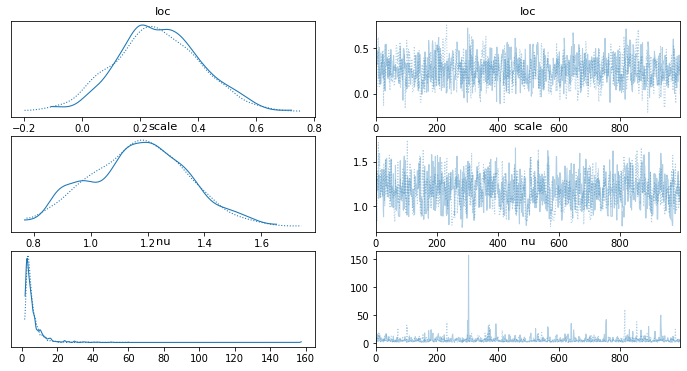

In [26]:
with model_3: 
    
    az.plot_trace(trace3)

We can compare the posteriors with the priors.

In [27]:
scale_kde =  ss.gaussian_kde(trace3['scale'])

nu_kde =  ss.gaussian_kde(trace3['nu'])


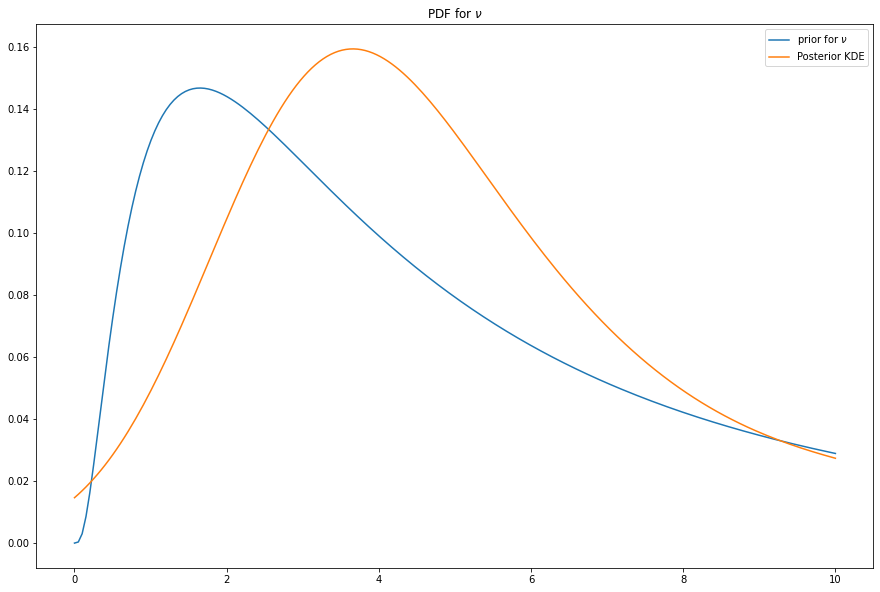

In [28]:
x = np.linspace(0.001,  10, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.lognorm.pdf(x, s= 1, scale = np.exp(1.5)), label="prior for $\\nu$")



plt.plot(x, nu_kde(x), label="Posterior KDE")


plt.legend()

plt.title("PDF for $\\nu$")

plt.show()

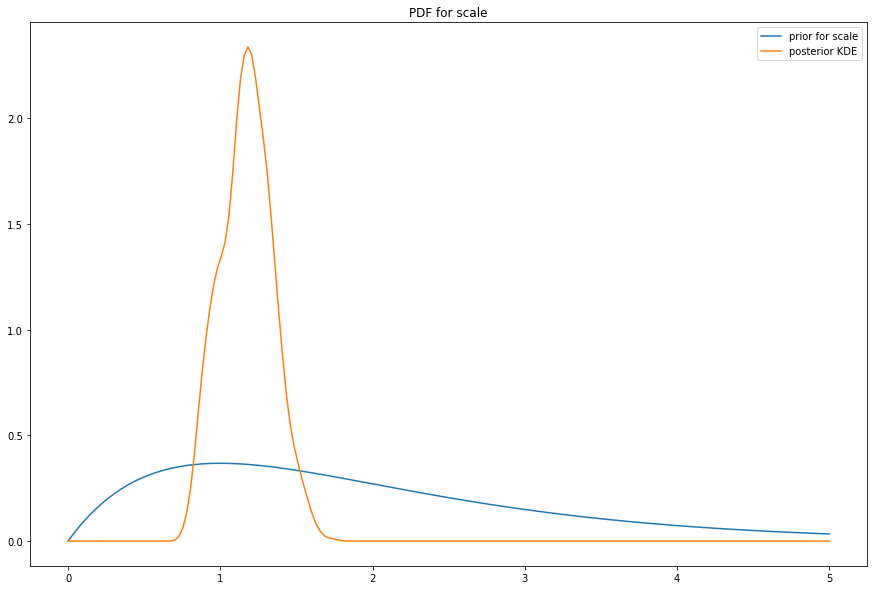

In [29]:
x = np.linspace(0.001,  5, 200)


plt.figure(figsize = (15,10))


plt.plot(x, ss.gamma.pdf(x, a=2, scale = 1), label="prior for scale")

plt.plot(x, scale_kde(x), label = "posterior KDE")


plt.legend()

plt.title("PDF for scale")

plt.show()

Now let's see how the scale and $nu$ distributions are depdendent.

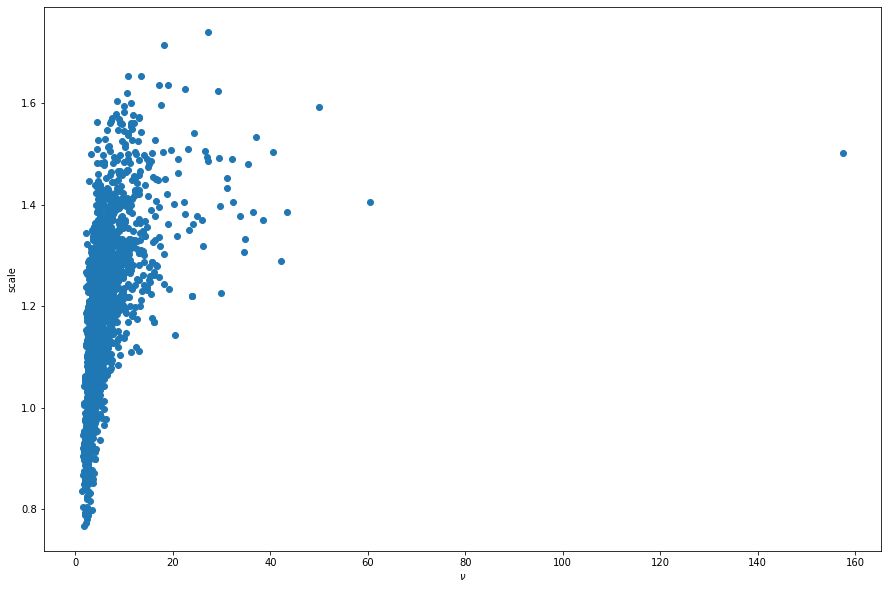

In [30]:
plt.figure(figsize = (15,10))

plt.scatter(trace3['nu'],trace3['scale'])

plt.xlabel("$\\nu$")

plt.ylabel("scale")
                   
plt.show()

We see that for larger values of $\nu$ go with larger values of scale.  But the relationship is clearly not linear.

#### Impact of sample size

There are two sample sizes here

1. The sample size of the actual data

2. The sample size we generate from the posterior


Making these larger will do different things depending on which one is made larger.

Making the data sample larger, will "tighten" the posteriors.  We will know more.

Making the MCMC sample larger will not change the posterior, but simply tell us more about it.

Let's do each in turn for the previous example.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, scale, loc]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8819364508460416, but should be close to 0.8. Try to increase the number of tuning steps.


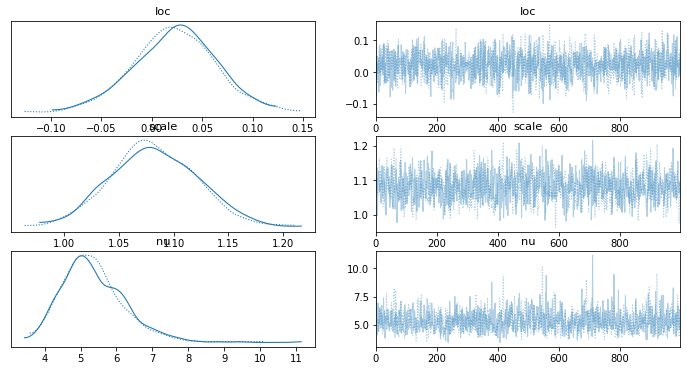

In [31]:
# Make data size larger

N = 1000

data3big = ss.t.rvs(df = 4, size = N)


model_3big = pm.Model()

with model_3big:
    
    #define the priors
    
    loc = pm.Uniform('loc', lower= -1, upper = 1)
    
    scale = pm.Gamma('scale', alpha =2, beta =1)
    
    nu = pm.Lognormal('nu', sigma = 1, mu = 1.5)
    
    
    #define the distribution of the observed variables
    
    Y_obs = pm.StudentT('Y_obs', nu = nu, mu = loc , sigma = scale,  observed=data3big)

    
    trace3big = pm.sample(1000)
    
    az.plot_trace(trace3big)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, scale, loc]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 12 seconds.


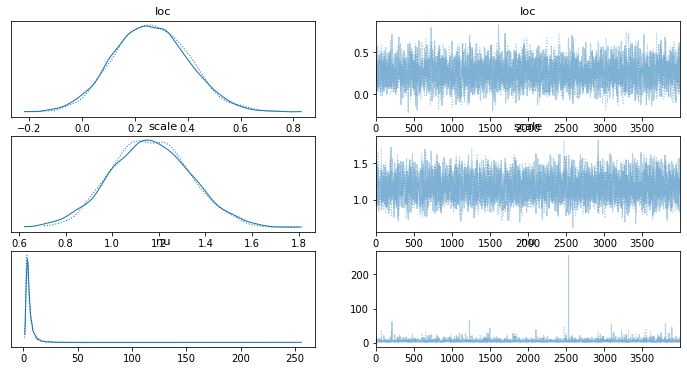

In [32]:
with model_3:

    trace3biggersample = pm.sample(4000)
    
    az.plot_trace(trace3biggersample)

## Comment on priors

Historically, one of the objections to Baysian analysis is that it required specifying the prior - which is "subjective".  If our priors are strong (small variance), them they will have a lot influence on our posteriors.  That isn't necessarily bad, but it could be if we are misinformed when setting our priors.

On the other hand, if we have weak priors, we may be failing to utilize information we already have.  Having said that, as long as the prior is not too strong and we have a fair amount of data, the prior actually does not matter that much.  


I will illustrate witt an example.    We will generate data from the exponential distribution $\lambda = 1$ and specify two priors for the $\lambda$ parameter.

Prior 1:  Normal with mean of $1.1$ and standard deviation of $0.1$

Prior 2:  Uniform on $[0.5,2]$





/usr/local/lib/python3.7/dist-packages/pymc3/distributions/continuous.py:138: UserWarning: The variable specified for lam has negative support for Exponential, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


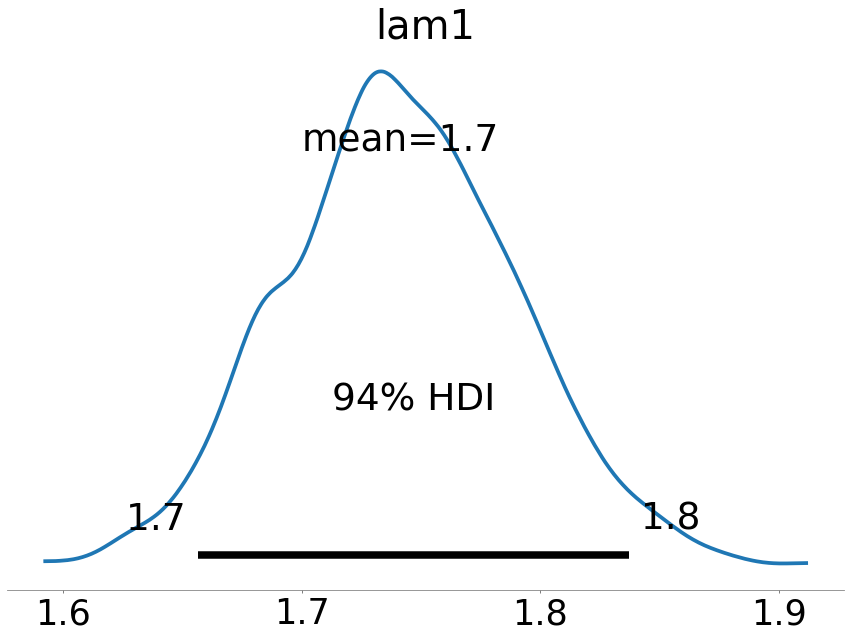

In [33]:
N = 1000

data = ss.expon.rvs(size = N, scale  = .51)

prior_ex1 = pm.Model()

with prior_ex1:
    
    lam1 = pm.Normal('lam1', mu = 1.1, sigma = 0.1)
    
    
    Yobs = pm.Exponential("Yobs", lam = lam1, observed = data)
    
    trace1 = pm.sample(1000)
    
    
    az.plot_posterior(trace1, figsize = (15,10))
    
    
    
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.


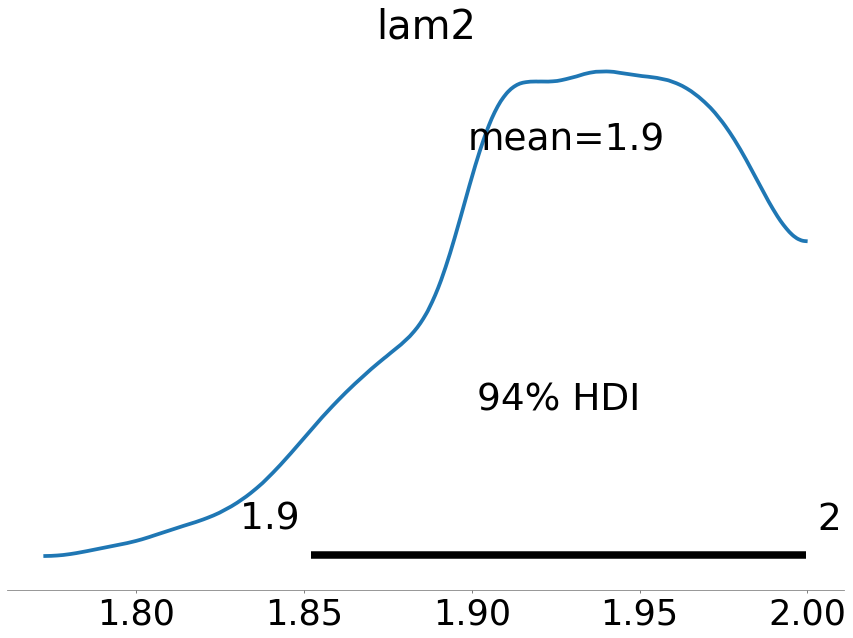

In [34]:
N = 1000


prior_ex2 = pm.Model()

with prior_ex2:
    
    lam2 = pm.Uniform('lam2', lower=0.5, upper= 2.0)
    
    
    Yobs = pm.Exponential("Yobs", lam = lam2, observed = data)
    
    trace2 = pm.sample(1000)
    
    
    az.plot_posterior(trace2, figsize = (15,10))

In [35]:
1/.6

1.6666666666666667

So, even though we started with two quite different priors, we end up in a similar place.


This leads to some general quidelines when setting priors:


1. Don't over-specify
2. The more data you have, the less important the prior.
3. The reasonable support of the prior should include all plausible parameter values.



## Some Real Data

We will get log-returns for the S&P500 and fit them to


1) Normal Distribution

2) Student T




In [36]:
import yfinance as yf

In [37]:
SP500 = yf.download('^GSPC',start = "2015-01-01", end = "2022-03-01")

SP500['lret'] = np.log(SP500.Close).diff()

SP500 = SP500.dropna()

SP500.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,lret
Date,,,,,,,
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,-0.018447
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,-0.008933
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,0.011563
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,0.017730
2015-01-09,2063.449951,2064.429932,2038.329956,2044.810059,2044.810059,3364140000,-0.008439


### Lognormal return model

We will frame the return and standard deviation parameters in annualized terms.  Let's set the priors but with no too much confidence.

In [38]:
SPM1 = pm.Model()


with SPM1:
    
    mu_a = pm.Normal('mu_a', mu = .05, sigma = .05)
    vol = pm.Uniform('vol', lower = .001, upper = .5)
    
    #we make them daily 
    
    mu_d = mu_a/252
    
    vol_d = vol/np.sqrt(252)
    
    
    # here is the model distribution
    
    Y = pm.Normal('Y', mu = mu_d, sigma = vol_d, observed = SP500.lret)
    
    
    
    
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vol, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


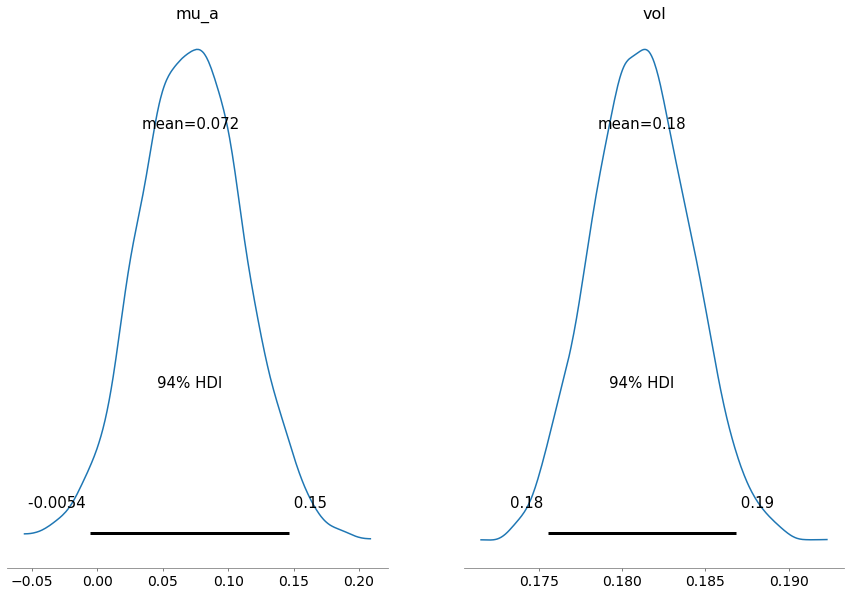

In [39]:
with SPM1:
    trace1 = pm.sample(2000)
    
    az.plot_posterior(trace1, figsize = (15,10))
    
    
    

### Comment

Note that there is quite a bit of uncertainty around the mean return parameter.    The volatility, not so much. 

This matters if you are optimizing portfolios - because the expected return is a key input.


### Student T version



Location will be the same prior as above.  For scale, the same (since if $\nu$ is large, scale is just vol.

For $\nu$, let's just take uniform on $[1,30]$.  There might be better choices, but we can defend this as follows:

If the degrees freedom is above $30$ this is basically the normal distribution. 

If the degree freedom is $1$ or less, the first moment is undefined, so we are talking very heavy returns. We should however take note if the posterior is showing probabilities near $1$ as being reasonably high. 

In [40]:
SPM2 = pm.Model()


with SPM2:
    
    mu_a = pm.Normal('mu_a', mu = .05, sigma = .05)
    scale_a = pm.Uniform('scale_a', lower = .001, upper = .5)
    
    
    nu = pm.Uniform('nu', lower = 1, upper = 30)
    
    #we make them daily 
    
    mu_d = mu_a/252
    
    scale = scale_a/np.sqrt(252)
    
    
    # here is the model distribution
    
    Y = pm.StudentT('Y',nu = nu,  mu = mu_d, sigma = scale, observed = SP500.lret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, scale_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


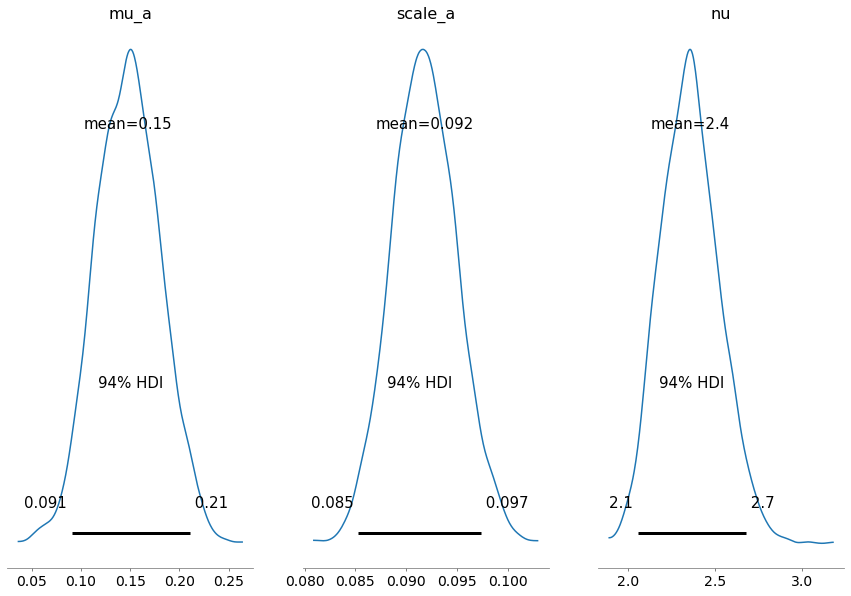

In [41]:
with SPM2:
    trace2 = pm.sample(2000)
    
    az.plot_posterior(trace2, figsize = (15,10))

### Comments

Interestingly, the view on the "mean" quite a but more optimistic.  This is probably (speculating) because the in log-normal model, a lower mean is required to deal with large negative returns. 

Note that the standard deviation of returns is $s_a \times \sqrt{\frac{\nu}{\nu-2}}$ where $s_a$ is the scale here).  

Let's create that data set and see what it looks like.

In [42]:
vols = trace2['scale_a']  * np.sqrt( trace2['nu']/(trace2['nu']-2)   )




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


The error message means that some of the sampled $\nu$ values are less than $2$. We place the data into a data frame and delete rows that are inconvenient.

In [43]:
import pandas as pd
t2data = pd.DataFrame([trace2['scale_a'], trace2['nu']]).T

t2data.columns = ['scale', 'nu']

t2data.head()


,scale,nu
0,0.088169,2.003072
1,0.087959,2.365615
2,0.090196,2.282117
3,0.093664,2.381666
4,0.096314,2.403030


In [44]:
t2data['vol'] = t2data.scale * np.sqrt(t2data.nu/(t2data.nu -2) ) 

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


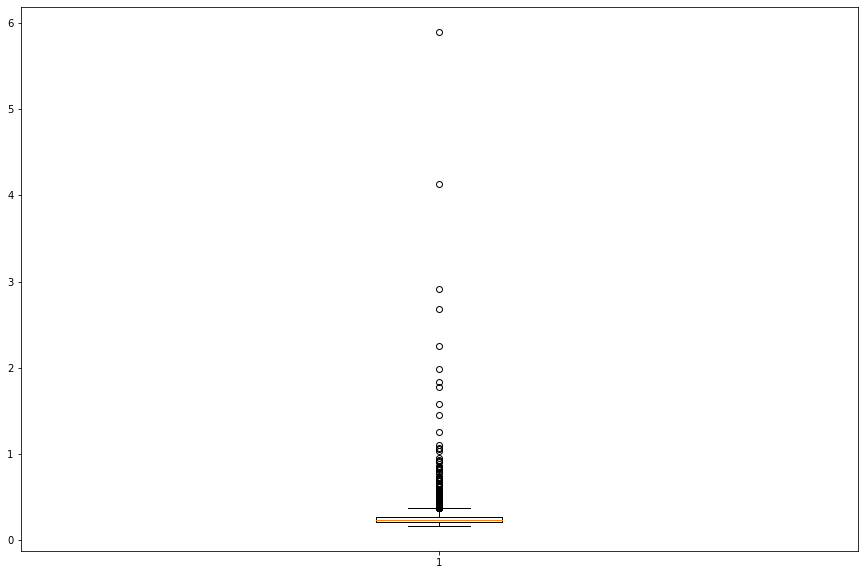

In [45]:
plt.figure(figsize = (15,10))

plt.boxplot(t2data.vol.dropna())

plt.show()

In [46]:
# Getting some more descriptive data 

t2data.vol.median(), t2data.vol.mean()

(0.23786934606002944, 0.2659824535706922)

In [47]:
np.percentile(t2data.vol.dropna(),25 ), np.percentile(t2data.vol.dropna(),75 )

(0.21474791906748783, 0.27723222293082694)

We see that the volatility is actually higher typically in this model than in the lognormal.




